In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.set_printoptions(threshold=sys.maxsize)

Exercise 5.12: Racetrack (programming) Consider driving a race car around a turn
like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as
to run off the track. In our simplified racetrack, the car is at one of a discrete set of
grid positions, the cells in the diagram. The velocity is also discrete, a number of grid
cells moved horizontally and vertically per time step. The actions are increments to the
velocity components. Each may be changed by +1, -1, or 0 in each step, for a total of
nine (3 x 3) actions. Both velocity components are restricted to be nonnegative and less
than 5, and they cannot both be zero except at the starting line. Each episode begins
in one of the randomly selected start states with both velocity components zero and
ends when the car crosses the finish line. The rewards are -1 for each step until the car
crosses the finish line. If the car hits the track boundary, it is moved back to a random
position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if
the projected path of the car intersects the track boundary. If it intersects the finish line,
the episode ends; if it intersects anywhere else, the car is considered to have hit the track
boundary and is sent back to the starting line. To make the task more challenging, with
probability 0.1 at each time step the velocity increments are both zero, independently of
the intended increments. Apply a Monte Carlo control method to this task to compute
the optimal policy from each starting state. Exhibit several trajectories following the
optimal policy (but turn the noise o↵ for these trajectories).

In [16]:
large_track = np.loadtxt("C:\\Users\\Joe\\Desktop\\Tufts Fall 2022\\CS 138\\HW2\\Large Track.txt")
large_track.shape

(30, 36)

In [17]:

lt_starting_line = np.where(large_track[29] == 1)[0]

lt_starting_line


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int64)

In [18]:
small_track = np.loadtxt("C:\\Users\\Joe\\Desktop\\Tufts Fall 2022\\CS 138\\HW2\\Small Track.txt")
small_track.shape

In [19]:

st_starting_line = np.where(small_track[31] == 1)[0]
st_starting_line

array([3, 4, 5, 6, 7, 8], dtype=int64)

In [21]:
lt_rows = large_track.shape[0]
lt_columns = large_track.shape[1]
st_rows = small_track.shape[0]
st_columns = small_track.shape[1]

In [22]:
actions = [[0,0],[0,1],[0,-1],[1,0],[1,1],[1,-1],[-1,0],[-1,1],[-1,-1]]
num_of_actions = len(actions)

In [23]:
vel_max = 4
vel_min = 0
vel_len = (vel_max-vel_min+1)
vel_len

5

In [24]:
#These are the Q-Frames for each track

large_Q = np.zeros(lt_rows*lt_columns*vel_len*vel_len*num_of_actions).reshape(lt_rows,lt_columns,vel_len, vel_len,num_of_actions)
small_Q = np.zeros(st_rows*st_columns*vel_len*vel_len*num_of_actions).reshape(st_rows,st_columns, vel_len, vel_len, num_of_actions)

In [25]:
class Track:

    def __init__(self, track, step_penalty, oob_penalty, finish_reward):
        self.track = track
        self.shape = track.shape
        self.step_penalty = step_penalty
        self.oob_penalty = oob_penalty
        self.finish_reward = finish_reward
        self.rows = self.shape[0]
        self.columns = self.shape[1]
        self.starting_line = np.where(self.track[self.rows-1] == 1)[0]

    def assign_starting_point(self):
        rand_index = np.random.randint(0,len(self.starting_line))
        starting_col = self.starting_line[rand_index]
        return [self.rows-1, starting_col]


In [26]:
l_track = Track(large_track, -1, -5, 20)
#step penalty -1, off-track -5, finish +20
s_track = Track(small_track, -1, -5, 20)

In [161]:
class Car:

    def __init__(self, epsilon, gamma,noise_ratio, allow_noise, episode_max, q_frame, avail_actions, vel_max, vel_min):
        self.epsilon = epsilon
        
        self.epsilon_shrink = False
        
        self.gamma = gamma
        self.allow_noise = allow_noise
        self.noise_ratio = noise_ratio
        self.vel_max = vel_max
        self.vel_min = vel_min
        self.vel_len = (vel_max-vel_min+1)
        self.episode_max = episode_max
        self.episode_count = 0
        self.q = np.copy(q_frame) #this is a multi dimensional array for each x, y, xvel, y vel, action return
        self.state_action_counts = q_frame*0 #this is the same but will just be counts for each one (for updating)
        self.actions = avail_actions 
        self.velocity = [0,0] #x is velocity moving right, y is velocity moving up
        self.position = [0,0] #so our velocity y will increment our pos x and our veloicty x will increment pos y
        self.rewards = list() #list of lists for each episode
        self.total_rewards = list()
        self.actions_taken = list() #list of lists for each episode
        self.velocities = list() #list of lists for each episode
        self.positions_in = list() #list of lists for each episode
        self.step_count_per_episode = list()
        self.start_spots = list() # list of where we started on each one
        self.victory_count = 0
        self.converged_episodes = list()
        self.last_short_rew = 0
        self.last_long_rew = 0
        self.can_end = False
        self.unique_spots_started = list()
       

    def avg_short_rew(self):
        if self.episode_count < 550:
            pass
        else:
            self.last_short_rew = 0
            for i in range(len(self.rewards)-300, len(self.rewards)):
                self.last_short_rew += sum(self.rewards[i])
            self.last_short_rew = self.last_short_rew/300


    def avg_long_rew(self):
        if self.episode_count < 2250:
            pass
        else:
            self.last_long_rew = 0
            for i in range(len(self.rewards)-2000, len(self.rewards)):
                self.last_long_rew += sum(self.rewards[i])
            self.last_long_rew = self.last_long_rew/2000
        
    def completion_check(self):
        #minimum episode condition
        #episode_count_check = (self.episode_count > 2500)

        #if episode_count_check:
            #self.epsilon = 0 ~~~~~~~~~~~~~  ~~(abs(self.last_50_rew/self.last_300_rew-1) < .01) ~~~~~~~(abs((self.victory_count/self.episode_count)/(1-self.epsilon)-1) < .01)
            if  (abs((self.victory_count/self.episode_count)/(1-self.epsilon)-1) < .01)   or (self.episode_count == self.episode_max):
                self.can_end = True
            
            '''
            
            all_reward_quantile = np.quantile(self.total_rewards, .75)
            recent_reward_quantile = np.quantile(self.total_rewards[-50:len(self.total_rewards)], self.epsilon)

            if recent_reward_quantile > all_reward_quantile:
                self.can_end = True'''

        
            
    
    def generate_possible_actions(self):
        x_vel = self.velocity[0]
        y_vel = self.velocity[1]
        x_possi = list()
        y_possi = list()

        #create a list of possible x accelerations
        if x_vel == self.vel_min:
            for i in range(0,len(self.actions)):
                if (self.actions[i][0] >= 0) and (self.actions[i][0] not in x_possi):
                    x_possi.append(self.actions[i][0])
        elif x_vel == self.vel_max:
            for i in range(0,len(self.actions)):
                if (self.actions[i][0] <= 0) and (self.actions[i][0] not in x_possi):
                    x_possi.append(self.actions[i][0])
        elif x_vel in range(self.vel_min+1, self.vel_max):
            for i in range(0,len(self.actions)):
                if (self.actions[i][0] not in x_possi):
                    x_possi.append(self.actions[i][0])
        #create a list of possible y accelerations
        if y_vel == self.vel_min:
            for i in range(0,len(self.actions)):
                if (self.actions[i][1] >= 0) and (self.actions[i][1] not in y_possi):
                    y_possi.append(self.actions[i][1])
        if y_vel == self.vel_max:
            for i in range(0,len(self.actions)):
                if (self.actions[i][1] <= 0) and (self.actions[i][1] not in y_possi):
                    y_possi.append(self.actions[i][1])
        elif y_vel in range(self.vel_min+1, self.vel_max):
            for i in range(0,len(self.actions)):
                if (self.actions[i][1] not in y_possi):
                    y_possi.append(self.actions[i][1])

        step_actions = list()
        #combine them together into all possible actions
        for x in x_possi:
            for y in y_possi:
                step_actions.append([x,y])
        #caveat that you can't have 0,0 velocity unless you're at the starting line -- this will prevent us from reaching 0,0
        if self.velocity == [1,0]:
            step_actions.remove([-1,0])
        elif self.velocity == [0,1]:
            step_actions.remove([0,-1])
        elif self.velocity == [1,1]:
            step_actions.remove([-1,-1])
        elif self.velocity == list([0,0]):
            step_actions.remove([0,0])

        return step_actions

    def choose_action(self, step_actions):
        '''if self.allow_noise:
            cutoff = (self.noise_ratio)*10000           Comes down to interpretation of instructions, I revised my interpretation to be: car chooses action, records action, but 0,0 is what is done
            roll = np.random.randint(1,10001)
            if roll < cutoff:
                action = list([0,0])
                return action
            else:
                pass'''
        cutoff = (1-self.epsilon)*10000
        roll = np.random.randint(1,10001)
        if roll <= cutoff: #take greedy action for that state
            #we want to take the action in the q array with the highest value -- even if its 0 as long as its possible
            #greedy_action = self.actions[greedy_action_index]
            avail_indics = list()
            for i in range(0,len(self.actions)):
                if self.actions[i] in step_actions:
                    avail_indics.append(i) #indicies of available actions given velocity these indicies correspond to the actions array with 9 values
            #print('Avail indics', avail_indics)
            #print(self.q[self.q[self.position[0], self.position[1], self.velocity[0],self.velocity[1], np.r_[avail_indics]]])
            try:
                avail_qas = self.q[self.position[0], self.position[1], self.velocity[0],self.velocity[1], np.r_[avail_indics]]
                action_index = np.argmax(avail_qas)
                max_indis =list()
                for i in range(0,len(avail_qas)):
                    if avail_qas[i] == avail_qas[action_index]:
                        max_indis.append(i)
                action_indind = np.random.randint(0,len(max_indis))
                action_index = max_indis[action_indind]

            #^this gives the index of the highest value in the Q table for that state subject to it being an avail_indics
            except:
                roll = 10000
                #print('Failed to be Greedy')
            else:
                action = step_actions[action_index] #action_index is in terms of the step_actions index so best action is this
                
                return action
        if roll > cutoff:
            rand_act_index = np.random.randint(0,len(step_actions))
            action = step_actions[rand_act_index]
            #print('explore')
            return action
            #return this to a variable, and then store that value so we keep track of each action
    

    #this was my original policy -- the issue was that it did not break ties arbitrarily so we updated to the above. Results seemed identical but this is more fair maybe over longer horizons
    '''def choose_action2(self, step_actions):
        if self.allow_noise:
            cutoff = (self.noise_ratio)*10000
            roll = np.random.randint(1,10001)
            if roll < cutoff:
                action = list([0,0])
                return action
            else:
                pass
        cutoff = (1-self.epsilon)*10000
        roll = np.random.randint(1,10001)
        if roll <= cutoff: #take greedy action for that state
            #we want to take the action in the q array with the highest value -- even if its 0 as long as its possible
            #greedy_action = self.actions[greedy_action_index]
            avail_indics = list()
            for i in range(0,len(self.actions)):
                if self.actions[i] in step_actions:
                    avail_indics.append(i) #indicies of available actions given velocity these indicies correspond to the actions array with 9 values
            #print('Avail indics', avail_indics)
            #print(self.q[self.q[self.position[0], self.position[1], self.velocity[0],self.velocity[1], np.r_[avail_indics]]])
            try:

                action_index = np.argmax(self.q[self.position[0], self.position[1], self.velocity[0],self.velocity[1], np.r_[avail_indics]])
                
            #^this gives the index of the highest value in the Q table for that state subject to it being an avail_indics
            except:
                roll = 10000
                #print('Failed to be Greedy')
            else:
                action = step_actions[action_index] #action_index is in terms of the step_actions index so best action is this
                
                return action
        if roll > cutoff:
            rand_act_index = np.random.randint(0,len(step_actions))
            action = step_actions[rand_act_index]
            #print('explore')
            return action
            #return this to a variable, and then store that value so we keep track of each action
            '''
    

    def update_meta_lists(self, start_spot,list_of_rewards, list_of_actions, list_of_positions, list_of_velocities, step_count):
        self.start_spots.append(start_spot)
        self.rewards.append(list_of_rewards)
        self.actions_taken.append(list_of_actions)
        self.positions_in.append(list_of_positions)
        self.velocities.append(list_of_velocities)
        self.step_count_per_episode.append(step_count)
        self.total_rewards.append(sum(list_of_rewards))
        if start_spot[1] not in self.unique_spots_started:
            self.unique_spots_started.append(start_spot[1])

        #now we need to update our Q table

        #generate returns
        returns = list()
        for i in range(len(list_of_rewards)-1, 0-1,-1):
            if i == len(list_of_rewards)-1:
                returns.append(list_of_rewards[i])
            else:
                g_return = list_of_rewards[i] + self.gamma*returns[len(returns)-1]
                returns.append(g_return)
        returns.reverse() #put them in same order as all other actions
        #print(returns)

        #now we need to add this into the q table. iterate through each state/action, icrement count and incrmeemnt average value
        
        
        for i in range(0,len(list_of_rewards)):
            index_of_action_taken = self.actions.index(list_of_actions[i])
            self.state_action_counts[list_of_positions[i][0],list_of_positions[i][1], list_of_velocities[i][0], list_of_velocities[i][1], index_of_action_taken] += 1
            n = self.state_action_counts[list_of_positions[i][0],list_of_positions[i][1], list_of_velocities[i][0], list_of_velocities[i][1], index_of_action_taken]
            delta = (1/n)*(returns[i] -self.q[list_of_positions[i][0],list_of_positions[i][1], list_of_velocities[i][0], list_of_velocities[i][1], index_of_action_taken] )
            
            self.q[list_of_positions[i][0],list_of_positions[i][1], list_of_velocities[i][0], list_of_velocities[i][1], index_of_action_taken] += delta

       
        
    def check_track_value(self,x,y,track):
        value = track.track[x,y]
        return value

    
    def check_oob(self,x_pos, y_pos, x_vel,y_vel,track):
        #y veloicty increments x_pos negatively
        #x veloicty increments y_pos positively
        
        if self.check_track_value(x_pos,y_pos+x_vel,track) == 0: #this is redundant but I was getting weird lines -- i figured out it was an issue with seaborn but im keeping this in bc compute4dayz
            return True

        for i in range(0,x_vel+1):
            for j in range(0,y_vel+1):
                 if self.check_track_value(x_pos-j, y_pos+i, track) == 0:
                    return True
    
        return False

        
        #these return True if the path of the car crosses out of bounds where the car travels first diagonally, and then either horizontally or vertically


    def check_finish(self,x_pos, y_pos, x_vel,y_vel,track):
        #copy the same thing above but return true if it equals 2  #I ended up revising the above to be more accurate but this still worked fine
        if x_vel == y_vel:
            for i in range(0,x_vel+1):
                if self.check_track_value(x_pos-i, y_pos+i,track) == 2:
                    return True
        if x_vel > y_vel:
            for i in range(0,y_vel):
                if self.check_track_value(x_pos-i, y_pos+i,track) == 2:
                    return True
            for j in range(y_vel+1,x_vel+1):
                if self.check_track_value(x_pos-y_vel, y_pos+j,track) == 2:
                    return True
        if x_vel < y_vel:
            for i in range(0,x_vel):
                if self.check_track_value(x_pos-i,y_pos+i, track) == 2:
                    return True
            for j in range(x_vel+1,y_vel+1):
                if self.check_track_value(x_pos-j, y_pos+x_vel, track) == 2:
                    return True

        else:
            return False
 

    def run_episode(self, start_spot, track):
        ep_rewards = list()
        ep_actions = list()
        ep_positions = list()
        ep_velocities = list()
        step_count = 0         
        racing = True
        self.position = list(start_spot)
        #print('starting spot', self.position)
        self.velocity = list([0,0])
        #print('startingspeed', self.velocity)
        ep_positions.append(self.position)
        ep_velocities.append(self.velocity)
        
        while racing:
            step_actions = self.generate_possible_actions()
            #print('possible actions', step_actions)
            action = self.choose_action(step_actions)
            #print('chosen action', action)
            ep_actions.append(action)

            if self.allow_noise:
                cutoff = (self.noise_ratio)*10000           
                roll = np.random.randint(1,10001)
                if roll < cutoff:
                    action = list([0,0])
                else:
                    pass

            self.velocity[0] += action[0]
            self.velocity[1] += action[1]
            #print('New speed',self.velocity)
            ep_velocities.append(list(self.velocity))
            step_count += 1
            
            if ((self.position[0] > track.rows-1) or (self.position[0] < 0)) or ((self.position[1] > track.columns-1) or (self.position[1] < 0)):
                #print('Fell off track')
                reward = track.oob_penalty
                ep_rewards.append(reward)
                self.position[0] = self.position[0] - self.velocity[1]
                self.position[1] = self.position[1] + self.velocity[0]
                #print('New Position',self.position)
                ep_positions.append(list(self.position))
                racing = False
                break
        
            elif self.check_finish(self.position[0], self.position[1], self.velocity[0], self.velocity[1], track):   
                    reward = track.finish_reward
                    ep_rewards.append(reward)
                    self.position[0] = self.position[0] - self.velocity[1]
                    self.position[1] = self.position[1] + self.velocity[0]
                    #print('New Position',self.position)
                    ep_positions.append(list(self.position))
                    self.victory_count += 1
                    racing = False
                    break

            elif self.check_oob(self.position[0], self.position[1], self.velocity[0], self.velocity[1], track):    
                    reward = track.oob_penalty
                    ep_rewards.append(reward)
                    self.position[0] = self.position[0] - self.velocity[1]
                    self.position[1] = self.position[1] + self.velocity[0]
                    #print('New Position',self.position)
                    ep_positions.append(list(self.position))
                    racing = False   
                    break

            else:
                    reward = track.step_penalty
                    ep_rewards.append(reward)
                    self.position[0] = self.position[0] - self.velocity[1]
                    self.position[1] = self.position[1] + self.velocity[0]
                    #print('New Position',self.position)
                    ep_positions.append(list(self.position))
                    #ep_velocities.append(self.velocity)
                    #ep_positions.append(self.position)

        ep_velocities[0] = [0,0] #for some reason i have to do these two things here otherwise i get crazy values in the first index
        ep_positions[0] = start_spot

        self.update_meta_lists(start_spot,ep_rewards, ep_actions, ep_positions, ep_velocities, step_count)
        
        self.episode_count += 1        
        self.avg_short_rew()
        self.avg_long_rew()
        self.completion_check()


       
        


    def let_me_take_the_wheel(self,start_spot, track ,epsiodes = 10): #the "epsiodes" actually doesn't get used
        #very similar to our run episode method except it asks for human input instead of choosing on its own
        ep_rewards = list()
        ep_actions = list()
        ep_positions = list()
        ep_velocities = list()
        step_count = 0         
        racing = True
        self.position = list(start_spot)
        #print('starting spot', self.position)
        self.velocity = list([0,0])
        #print('startingspeed', self.velocity)
        ep_positions.append(self.position)
        ep_velocities.append(self.velocity)
        print('You start at ', self.position)
        print('Velocity is ', self.velocity)
        print('First digit increments horitzonal movement, second increments vertical')
        samp_grid = np.copy(track.track)

        while racing:
            print('Current Episode Count', self.episode_count)
            samp_grid[self.position[0], self.position[1]] = 1 # we are going to mark where we are with a 9 (printing out a section of the array), so here we set our old spot back to 1
            step_actions = self.generate_possible_actions()
            print('Possible Actions: ', step_actions)
            action = list()
            x_action = int(input('What is your first/horizontal increment? '))
            action.append(x_action)
            y_action = int(input('What is your second/vertical increment? '))
            action.append(y_action)
            if action not in step_actions:
                print('Your entry is invalid, try:')
                print(self.choose_action(step_actions))
                action = self.choose_action(step_actions) #skynet chooses for you
                
            ep_actions.append(action)
            self.velocity[0] += action[0]
            self.velocity[1] += action[1]
            print('New speed',self.velocity)
            ep_velocities.append(list(self.velocity))
            step_count += 1

            if ((self.position[0] > track.rows-1) or (self.position[0] < 0)) or ((self.position[1] > track.columns-1) or (self.position[1] < 0)):
                
                reward = track.oob_penalty
                ep_rewards.append(reward)
                print('You fell off the track')
                self.position[0] = self.position[0] - self.velocity[1]
                self.position[1] = self.position[1] + self.velocity[0]
                #print('New Position',self.position)
                ep_positions.append(list(self.position))
                racing = False
                break

            elif self.check_finish(self.position[0], self.position[1], self.velocity[0],self.velocity[1],track):   #  .check_win_condition()
                    reward = track.finish_reward
                    ep_rewards.append(reward)
                    print('You finished!')
                    self.position[0] = self.position[0] - self.velocity[1]
                    self.position[1] = self.position[1] + self.velocity[0]
                    #print('New Position',self.position)
                    ep_positions.append(list(self.position))
                    self.victory_count += 1
                    racing = False
                    break
                
            elif self.check_oob(self.position[0], self.position[1], self.velocity[0],self.velocity[1],track):    
                    reward = track.oob_penalty
                    ep_rewards.append(reward)
                    print('You went out of bounds')
                    self.position[0] = self.position[0] - self.velocity[1]
                    self.position[1] = self.position[1] + self.velocity[0]
                    #print('New Position',self.position)
                    ep_positions.append(list(self.position))
                    #ep_velocities.append(self.velocity)
                    #ep_positions.append(self.position)
                    racing = False   
                    break
         
            else:
                    reward = track.step_penalty
                    ep_rewards.append(reward)
                    self.position[0] = self.position[0] - self.velocity[1]
                    self.position[1] = self.position[1] + self.velocity[0]
                    print('New Position',self.position)
                    ep_positions.append(list(self.position))

                    samp_grid[self.position[0], self.position[1]] = 9
                    track_row_min_index = max(self.position[0]-3,0)
                    track_row_max_index = min(self.position[0] + 3, track.rows)
                    track_col_min_index = max(self.position[1]-3,0)
                    track_col_max_index = min(self.position[1]+3, track.columns)

                    print(samp_grid[track_row_min_index:track_row_max_index, track_col_min_index:track_col_max_index])



        ep_velocities[0] = [0,0] #for some reason i have to do these two things here otherwise i get crazy values in the first index
        ep_positions[0] = start_spot

        self.update_meta_lists(start_spot,ep_rewards, ep_actions, ep_positions, ep_velocities, step_count)
        
        self.episode_count += 1    
        self.avg_short_rew()
        self.avg_long_rew()
        self.completion_check()

    def print_stats(self):
        print('episode count', self.episode_count)
        print('highest reward',max(self.total_rewards))
        print('last short average',self.last_short_rew)

        print('last long avg rew',self.last_long_rew)

        print('last 50 quantile',np.quantile(self.total_rewards[-50:len(self.total_rewards)],.5))
        print('total quantile', np.quantile(self.total_rewards,.75))

        print('Victory Count',self.victory_count)
        print('% Vicotry',self.victory_count/self.episode_count)
        print('Diff from Epsilon', self.victory_count/self.episode_count/(1-self.epsilon)-1)
    



In [28]:
###Building the first simulation on the large track

In [129]:
racecar = Car(epsilon=.1, gamma= .5,noise_ratio=.1,allow_noise=True,episode_max = 250000, q_frame =large_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [ ]:
#below is creating the car for creating the human q-frame. It's commented out so that the q-frame isn't overriden

In [61]:
#my_car = Car(epsilon=.1, gamma= .5,noise_ratio=.1,allow_noise=True,episode_max = 250000, q_frame =large_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [130]:
#Run our first racecar on the large track with noise

np.random.seed(1)



while racecar.can_end == False:
    racecar.run_episode(l_track.assign_starting_point(), l_track)
   
    

avg_rewards = list()
for i in range(0,len(racecar.rewards)):
    avg_rew = sum(racecar.rewards[i])
    avg_rewards.append(avg_rew)

avg_rewards = np.array(avg_rewards)

racecar.episode_count

140734

In [72]:
#generate human q values on the large track

np.random.seed(1)

while my_car.episode_count < 10:
     my_car.let_me_take_the_wheel(l_track.assign_starting_point(), l_track)
human_10_eps_frame = np.copy(my_car.q)

while my_car.episode_count < 20:
    my_car.let_me_take_the_wheel(l_track.assign_starting_point(), l_track)

human_20_eps_frame = np.copy(my_car.q)



You start at  [29, 5]
Velocity is  [0, 0]
First digit increments horitzonal movement, second increments vertical
Current Episode Count 16
Possible Actions:  [[0, 1], [1, 0], [1, 1]]
New speed [1, 1]
New Position [28, 6]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 9. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Current Episode Count 16
Possible Actions:  [[0, 0], [0, 1], [0, -1], [1, 0], [1, 1], [1, -1], [-1, 0], [-1, 1]]
New speed [2, 2]
New Position [26, 8]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 9. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Current Episode Count 16
Possible Actions:  [[0, 0], [0, 1], [0, -1], [1, 0], [1, 1], [1, -1], [-1, 0], [-1, 1], [-1, -1]]
New speed [2, 3]
New Position [23, 10]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 9. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Current Episode Count 16
Possible Actions:  [[0, 0], [0, 1], [0, -1], [1, 0], [1, 1], [1, -1], [-1, 0], [-1

'\nwhile my_car.can_end == False:\n    my_car.run_episode(l_track.assign_starting_point(), l_track)\n   \n    \n\nmy_avg_rewards = list()\nfor i in range(0,len(my_car.rewards)):\n    my_avg_rew = sum(my_car.rewards[i])\n    my_avg_rewards.append(my_avg_rew)\n\nmy_avg_rewards = np.array(my_avg_rewards)\n'

In [73]:
print('My Episode Count', my_car.episode_count)
print('Racecar Episode Count', racecar.episode_count)

My Episode Count 20
Racecar Episode Count 140734


In [150]:
#these series of print statements ended up getting built in as a method

print('episode count',racecar.episode_count)
print('highest reward',max(racecar.total_rewards))
print('last short average',racecar.last_short_rew)

print('last long avg rew',racecar.last_long_rew)

print('quantile',np.quantile(racecar.total_rewards[-50:len(racecar.total_rewards)],.5))
print('total quantile', np.quantile(racecar.total_rewards,.75))

print(racecar.victory_count)
print(racecar.victory_count/racecar.episode_count)
print(racecar.victory_count/racecar.episode_count/(1-racecar.epsilon)-1)

episode count 140734
highest reward 12
last short average 8.113333333333333
last long avg rew 7.9045
quantile 9.0
total quantile 11.0
125394
0.8910000426336209
-0.009999952629310194


In [115]:
'''plotaxis = np.arange(1,len(avg_rewards)+1)

plt.figure(figsize=(30,10))
sns.lineplot(x=plotaxis, y = avg_rewards)
plt.show;
'''

'plotaxis = np.arange(1,len(avg_rewards)+1)\n\nplt.figure(figsize=(30,10))\nsns.lineplot(x=plotaxis, y = avg_rewards)\nplt.show;\n'

In [75]:
#Creating Trajectories for the large track racecar with noise

trajectories = list() #list of positions
traj_actions = list() #list of all actions
for start_spot in range(0,len(l_track.starting_line)):
    path = list()
    path_actions = list()
    not_finished = True
    position = list([l_track.rows-1,start_spot])
    velocity = list([0,0])
    path.append(list(position))
    while not_finished:
        if velocity != list([0,0]): #so everywhere except the starting line
            mask = (racecar.q[position[0], position[1], velocity[0],velocity[1]] != 0)
            sub_ind = np.argmax(racecar.q[position[0], position[1], velocity[0],velocity[1]][mask])
            full_ind = np.arange(racecar.q.shape[4])[mask][sub_ind]
            path_action = actions[full_ind] #this is the optimal action taken at this location
        else: 
            mask = (racecar.q[position[0], position[1], velocity[0],velocity[1]] != 0)[1:9]
            sub_ind = np.argmax(racecar.q[position[0], position[1], velocity[0],velocity[1]][1:9][mask])
            full_ind = np.arange(racecar.q.shape[4]-1)[mask][sub_ind]
            path_action = actions[full_ind+1] #this is the optimal action taken at this location
        path_actions.append(list(path_action))
        velocity[0] += path_action[0]
        velocity[1] += path_action[1]
        position[0] = max(position[0] - velocity[1],0)
        position[1] += velocity[0]
        path.append(list(position))
        if (l_track.track[position[0], position[1]] == 2) or (position[0] < 0):
            not_finished = False
            break
        
    trajectories.append(list(path))
    traj_actions.append(list(path_actions))

print(len(racecar.rewards))
        




140734


(0.0, 35.0)

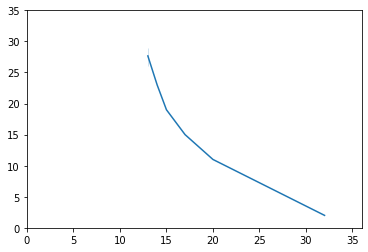

In [203]:
test_x_axis = list()
test_y_axis = list()

col = 13

for i in range(0,len(trajectories[col])):
    test_x_axis.append(trajectories[col][i][0])
    test_y_axis.append(trajectories[col][i][1])

test_x_axis=np.array(test_x_axis)
test_y_axis=np.array(test_y_axis)

sns.lineplot(x=test_y_axis, y=test_x_axis)
plt.xlim([0,36])
plt.ylim([0,35])

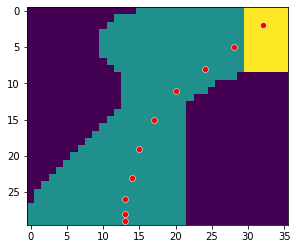

In [204]:
sns.scatterplot(x=test_y_axis, y=test_x_axis, color = 'Red', lw =2, estimator=np.max)


plt.imshow(large_track)
plt.show()

In [ ]:
### now run a new racecar that uses my_car's q frame

1.0

In [137]:
hybrid_car = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=True, episode_max= 250000, q_frame= human_20_eps_frame, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [138]:
hybrid_car.state_action_counts = my_car.state_action_counts * 10   # i want to give more weight to the human moves
hybrid_car.episode_count = my_car.episode_count * 10

In [139]:
np.random.seed(1)



while hybrid_car.can_end == False:
    hybrid_car.run_episode(l_track.assign_starting_point(), l_track)
   
    

hybrid_avg_rewards = list()
for i in range(0,len(hybrid_car.rewards)):
    hybrid_avg_rew = sum(hybrid_car.rewards[i])
    hybrid_avg_rewards.append(hybrid_avg_rew)

hybrid_avg_rewards = np.array(hybrid_avg_rewards)


In [140]:
print('episode count',hybrid_car.episode_count)
print('highest reward',max(hybrid_car.total_rewards))
print('last short average',hybrid_car.last_short_rew)

print('last long avg rew',hybrid_car.last_long_rew)

print('quantile',np.quantile(hybrid_car.total_rewards[-50:len(hybrid_car.total_rewards)],.5))
print('total quantile', np.quantile(hybrid_car.total_rewards,.75))

print('Victory Count',hybrid_car.victory_count)
print(hybrid_car.victory_count/hybrid_car.episode_count)
print(hybrid_car.victory_count/hybrid_car.episode_count/(1-hybrid_car.epsilon)-1)


episode count 172505
highest reward 12
last short average 8.56
last long avg rew 8.3065
quantile 10.0
total quantile 11.0
Victory Count 153702
0.891000260862004
-0.0099997101533289


In [141]:
nn_hybrid_car = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=False, episode_max= 250000, q_frame= human_20_eps_frame, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [142]:
nn_hybrid_car.state_action_counts = my_car.state_action_counts * 10   # i want to give more weight to the human moves
nn_hybrid_car.episode_count = my_car.episode_count * 10

In [143]:
np.random.seed(1)

#while racecar.episode_count < 1:
 # racecar.let_me_take_the_wheel(l_track.assign_starting_point(), l_track)

while nn_hybrid_car.can_end == False:
    nn_hybrid_car.run_episode(l_track.assign_starting_point(), l_track)
   
    

nn_hybrid_avg_rewards = list()
for i in range(0,len(nn_hybrid_car.rewards)):
    nn_hybrid_avg_rew = sum(nn_hybrid_car.rewards[i])
    nn_hybrid_avg_rewards.append(nn_hybrid_avg_rew)

nn_hybrid_avg_rewards = np.array(nn_hybrid_avg_rewards)


In [144]:
print('episode count',nn_hybrid_car.episode_count)
print('highest reward',max(nn_hybrid_car.total_rewards))
print('last short average',nn_hybrid_car.last_short_rew)

print('last long avg rew',nn_hybrid_car.last_long_rew)

print('quantile',np.quantile(nn_hybrid_car.total_rewards[-50:len(nn_hybrid_car.total_rewards)],.5))
print('total quantile', np.quantile(nn_hybrid_car.total_rewards,.75))

print(nn_hybrid_car.victory_count)
print(nn_hybrid_car.victory_count/nn_hybrid_car.episode_count)
print(nn_hybrid_car.victory_count/nn_hybrid_car.episode_count/(1-nn_hybrid_car.epsilon)-1)

episode count 70257
highest reward 12
last short average 9.526666666666667
last long avg rew 9.26
quantile 11.0
total quantile 12.0
62599
0.8910001850349432
-0.009999794405618712


In [145]:
nn_racecar = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=False, episode_max= 250000, q_frame= large_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [146]:
np.random.seed(1)


while nn_racecar.can_end == False:
    nn_racecar.run_episode(l_track.assign_starting_point(), l_track)
   
    

nn_avg_rewards = list()
for i in range(0,len(nn_racecar.rewards)):
    nn_avg_rew = sum(nn_racecar.rewards[i])
    nn_avg_rewards.append(nn_avg_rew)

nn_avg_rewards = np.array(nn_avg_rewards)


In [147]:
print('episode count',nn_racecar.episode_count)
print('highest reward',max(nn_racecar.total_rewards))
print('last short average',nn_racecar.last_short_rew)

print('last long avg rew',nn_racecar.last_long_rew)

print('quantile',np.quantile(nn_racecar.total_rewards[-50:len(nn_racecar.total_rewards)],.5))
print('total quantile', np.quantile(nn_racecar.total_rewards,.75))

print(nn_racecar.victory_count)
print(nn_racecar.victory_count/nn_racecar.episode_count)
print(nn_racecar.victory_count/nn_racecar.episode_count/(1-nn_racecar.epsilon)-1)

episode count 68643
highest reward 12
last short average 9.08
last long avg rew 9.0175
quantile 10.0
total quantile 11.0
61161
0.8910012674271229
-0.009998591747641172


In [187]:
lt_car_meta_data = pd.DataFrame({
    'Car_Type' : ['LT Racecar with Noise', 'LT Racecar with Noise and Human Boost', 'LT Racecar with No Noise','LT Racecar with No Noise and Human Boost'],
    'Total_Episodes' : [racecar.episode_count, hybrid_car.episode_count, nn_racecar.episode_count, nn_hybrid_car.episode_count],
    'Total_Finishes' : [racecar.victory_count, hybrid_car.victory_count, nn_racecar.victory_count, nn_hybrid_car.victory_count],
    'Final_Victory_Pct' : [racecar.victory_count/racecar.episode_count, hybrid_car.victory_count/hybrid_car.episode_count, nn_racecar.victory_count/nn_racecar.episode_count, nn_hybrid_car.victory_count/nn_hybrid_car.episode_count],
    'Last_50_Avg_Reward' : [racecar.last_short_rew, hybrid_car.last_short_rew, nn_racecar.last_short_rew, nn_hybrid_car.last_short_rew]
})

lt_car_meta_data

,Car_Type,Total_Episodes,Total_Finishes,Final_Victory_Pct,Last_50_Avg_Reward
0,LT Racecar with Noise,140734,125394,0.891000,8.113333
1,LT Racecar with Noise and Human Boost,172505,153702,0.891000,8.560000
2,LT Racecar with No Noise,68643,61161,0.891001,9.080000
3,LT Racecar with No Noise and Human Boost,70257,62599,0.891000,9.526667


In [ ]:
################################~~~~~~~~~~ SMALL TRACK TIME ~~~~~~~~~~~~~~~~~############################################

In [153]:
small_racecar = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=True, episode_max= 400000, q_frame= small_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [154]:
np.random.seed(1)


while small_racecar.can_end == False:
    small_racecar.run_episode(s_track.assign_starting_point(), s_track)
   
    

small_rc_avg_rews = list()
for i in range(0,len(small_racecar.rewards)):
    small_rc_avg_rew = sum(small_racecar.rewards[i])
    small_rc_avg_rews.append(small_rc_avg_rew)

small_rc_avg_rews = np.array(small_rc_avg_rews)


In [174]:
print('episode count',small_racecar.episode_count)
print('highest reward',max(small_racecar.total_rewards))
print('last short average',small_racecar.last_short_rew)

print('last long avg rew',small_racecar.last_long_rew)

print('quantile',np.quantile(small_racecar.total_rewards[-50:len(small_racecar.total_rewards)],.5))
print('total quantile', np.quantile(small_racecar.total_rewards,.75))

print(small_racecar.victory_count)
print(small_racecar.victory_count/small_racecar.episode_count)
print(small_racecar.victory_count/small_racecar.episode_count/(1-small_racecar.epsilon)-1)

episode count 400000
highest reward 10
last short average 0.13666666666666666
last long avg rew 1.015
quantile 6.5
total quantile 8.0
280344
0.70086
-0.2212666666666666


In [156]:
#trajectories for the racecar on the small trak with noise

small_trajectories = list() #list of positions
small_traj_actions = list() #list of all actions
for start_spot in range(min(s_track.starting_line),max(s_track.starting_line)+1):
    path = list()
    path_actions = list()
    not_finished = True
    position = list([s_track.rows-1,start_spot])
    velocity = list([0,0])
    path.append(list(position))
    while not_finished:
        if velocity != list([0,0]):
            mask = (small_racecar.q[position[0], position[1], velocity[0],velocity[1]] != 0)
            sub_ind = np.argmax(small_racecar.q[position[0], position[1], velocity[0],velocity[1]][mask])
            full_ind = np.arange(small_racecar.q.shape[4])[mask][sub_ind]
            path_action = actions[full_ind] #this is the optimal action taken at this location
        else:
            mask = (small_racecar.q[position[0], position[1], velocity[0],velocity[1]] != 0)[1:9]
            sub_ind = np.argmax(small_racecar.q[position[0], position[1], velocity[0],velocity[1]][1:9][mask])
            full_ind = np.arange(small_racecar.q.shape[4]-1)[mask][sub_ind]
            path_action = actions[full_ind+1] #this is the optimal action taken at this location
        path_actions.append(list(path_action))
        velocity[0] += path_action[0]
        velocity[1] += path_action[1]
        position[0] = max(position[0] - velocity[1],0)
        position[1] += velocity[0]
        path.append(list(position))
        if (s_track.track[position[0], position[1]] == 2) or (position[0] < 0):
            not_finished = False
            break
        
    small_trajectories.append(list(path))
    small_traj_actions.append(list(path_actions))
  

(0.0, 35.0)

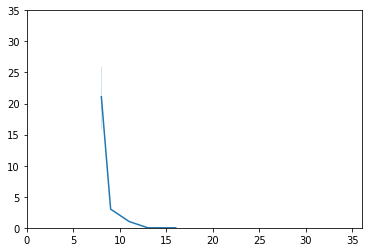

In [209]:
test_x_axis = list()
test_y_axis = list()

col =  len(small_trajectories)-1

for i in range(0,len(small_trajectories[col])):
    test_x_axis.append(small_trajectories[col][i][0])
    test_y_axis.append(small_trajectories[col][i][1])

test_x_axis=np.array(test_x_axis)
test_y_axis=np.array(test_y_axis)

sns.lineplot(x=test_y_axis, y=test_x_axis)
plt.xlim([0,36])
plt.ylim([0,35])

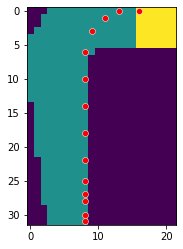

In [210]:
sns.scatterplot(x=test_y_axis, y=test_x_axis, color = 'Red', lw =2, estimator=np.max)


plt.imshow(small_track)
plt.show()

In [ ]:
####Create my small track car #####

In [165]:
#my_st_car = Car(epsilon=.1, gamma= .5,noise_ratio=.1,allow_noise=True,episode_max = 400000, q_frame =small_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [166]:
np.random.seed(1)

while my_st_car.episode_count < 10:
     my_st_car.let_me_take_the_wheel(s_track.assign_starting_point(), s_track)
human_st_10_eps_frame = np.copy(my_st_car.q)

while my_st_car.episode_count < 20:
    my_st_car.let_me_take_the_wheel(s_track.assign_starting_point(), s_track)

human_st_20_eps_frame = np.copy(my_st_car.q)


You start at  [31, 8]
Velocity is  [0, 0]
First digit increments horitzonal movement, second increments vertical
Current Episode Count 0
Possible Actions:  [[0, 1], [1, 0], [1, 1]]
New speed [0, 1]
New Position [30, 8]
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 9. 0. 0.]
 [1. 1. 1. 1. 0. 0.]]
Current Episode Count 0
Possible Actions:  [[0, 0], [0, 1], [1, 0], [1, 1], [1, -1]]
New speed [0, 2]
New Position [28, 8]
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 9. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]]
Current Episode Count 0
Possible Actions:  [[0, 0], [0, 1], [0, -1], [1, 0], [1, 1], [1, -1]]
New speed [0, 3]
New Position [25, 8]
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 9. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]]
Current Episode Count 0
Possible Actions:  [[0, 0], [0, 1], [0, -1], [1, 0], [1, 1], [1, -1]]
New speed [0, 4]
New Position [21, 8]
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1.

In [ ]:
#### Create small track hybrid car

In [170]:
st_hybrid_car = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=True, episode_max= 400000, q_frame= human_st_20_eps_frame, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [171]:
st_hybrid_car.state_action_counts = my_st_car.state_action_counts * 10   # i want to give more weight to the human moves
st_hybrid_car.episode_count = my_st_car.episode_count * 10

In [172]:
np.random.seed(1)


while st_hybrid_car.can_end == False:
    st_hybrid_car.run_episode(s_track.assign_starting_point(), s_track)
   
st_hybrid_car.print_stats()    



episode count 400000
highest reward 10
last short average 0.9033333333333333
last long avg rew 1.032
last 50 quantile 8.0
total quantile 9.0
Victory Count 267393
% Vicotry 0.6684825
Diff from Epsilon -0.2572416666666667


In [ ]:
#### Create small track no noise car

In [175]:
small_nn_racecar = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=False, episode_max= 400000, q_frame= small_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [176]:
np.random.seed(1)


while small_nn_racecar.can_end == False:
    small_nn_racecar.run_episode(s_track.assign_starting_point(), s_track)
   
small_nn_racecar.print_stats()    



episode count 400000
highest reward 10
last short average 3.203333333333333
last long avg rew 3.8415
last 50 quantile 8.5
total quantile 10.0
Victory Count 302484
% Vicotry 0.75621
Diff from Epsilon -0.1597666666666666


In [159]:
####Create small track no noise hybrid car

In [177]:
small_nn_hybrid_car = Car(epsilon = .1, gamma = .5, noise_ratio=.1, allow_noise=False, episode_max= 400000, q_frame= small_Q, avail_actions= actions, vel_max= vel_max, vel_min = vel_min)

In [178]:
small_nn_hybrid_car.state_action_counts = my_st_car.state_action_counts * 10   # i want to give more weight to the human moves
small_nn_hybrid_car.episode_count = my_st_car.episode_count * 10

In [179]:
np.random.seed(1)



while small_nn_hybrid_car.can_end == False:
    small_nn_hybrid_car.run_episode(s_track.assign_starting_point(), s_track)
   
small_nn_hybrid_car.print_stats()    



episode count 400000
highest reward 10
last short average 5.083333333333333
last long avg rew 4.755
last 50 quantile 9.0
total quantile 10.0
Victory Count 313303
% Vicotry 0.7832575
Diff from Epsilon -0.1297138888888889


In [184]:
st_car_meta_data = pd.DataFrame({
    'Car_Type' : ['ST Racecar with Noise', 'ST Racecar with Noise and Human Boost', 'ST Racecar with No Noise','ST Racecar with No Noise and Human Boost'],
    'Total_Episodes' : [small_racecar.episode_count, st_hybrid_car.episode_count, small_nn_racecar.episode_count, small_nn_hybrid_car.episode_count],
    'Total_Finishes' : [small_racecar.victory_count, st_hybrid_car.victory_count, small_nn_racecar.victory_count, small_nn_hybrid_car.victory_count],
    'Final_Victory_Pct' : [small_racecar.victory_count/small_racecar.episode_count, st_hybrid_car.victory_count/st_hybrid_car.episode_count, small_nn_racecar.victory_count/small_nn_racecar.episode_count, small_nn_hybrid_car.victory_count/small_nn_hybrid_car.episode_count],
    'Last_50_Avg_Reward' : [small_racecar.last_short_rew, st_hybrid_car.last_short_rew, small_nn_racecar.last_short_rew, small_nn_hybrid_car.last_short_rew]
})

st_car_meta_data

,Car_Type,Total_Episodes,Total_Finishes,Final_Victory_Pct,Last_50_Avg_Reward
0,ST Racecar with Noise,400000,280344,0.700860,0.136667
1,ST Racecar with Noise and Human Boost,400000,267393,0.668482,0.903333
2,ST Racecar with No Noise,400000,302484,0.756210,3.203333
3,ST Racecar with No Noise and Human Boost,400000,313303,0.783258,5.083333


In [193]:
lt_car_meta_data.filter(items = [0,2],axis=0)

,Car_Type,Total_Episodes,Total_Finishes,Final_Victory_Pct,Last_50_Avg_Reward
0,LT Racecar with Noise,140734,125394,0.891000,8.113333
2,LT Racecar with No Noise,68643,61161,0.891001,9.080000


In [196]:
st_car_meta_data.filter(items = [0,2], axis =0)

,Car_Type,Total_Episodes,Total_Finishes,Final_Victory_Pct,Last_50_Avg_Reward
0,ST Racecar with Noise,400000,280344,0.70086,0.136667
2,ST Racecar with No Noise,400000,302484,0.75621,3.203333


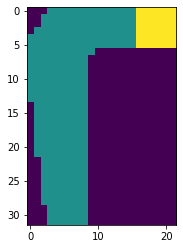

In [195]:
plt.imshow(small_track)
plt.show()

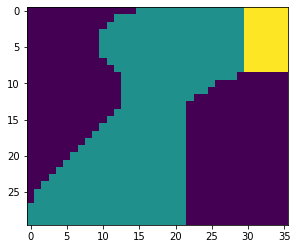

In [194]:
plt.imshow(large_track)
plt.show()

In [211]:
lt_car_meta_data

,Car_Type,Total_Episodes,Total_Finishes,Final_Victory_Pct,Last_50_Avg_Reward
0,LT Racecar with Noise,140734,125394,0.891000,8.113333
1,LT Racecar with Noise and Human Boost,172505,153702,0.891000,8.560000
2,LT Racecar with No Noise,68643,61161,0.891001,9.080000
3,LT Racecar with No Noise and Human Boost,70257,62599,0.891000,9.526667
